# Importing libraries

In [112]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import urllib.request
import urllib
import tarfile
from natsort import natsorted 

# Dataset

## Download

In [113]:
# def download_and_extract_oxford_pet_dataset(destination_folder):
#     """
#     Baixa e extrai o Oxford-IIIT Pet Dataset (imagens e anotações).
    
#     :param destination_folder: Caminho do diretório onde os arquivos serão salvos e extraídos.
#     """
#     # URLs dos arquivos
#     urls = {
#         "images": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
#         "annotations": "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
#     }
    
#     # Criar a pasta de destino, se não existir
#     os.makedirs(destination_folder, exist_ok=True)
    
#     for key, url in urls.items():
#         print(f"Baixando {key}...")
#         file_name = os.path.join(destination_folder, url.split("/")[-1])
        
#         # Fazer o download do arquivo
#         urllib.request.urlretrieve(url, file_name)
#         print(f"Download concluído: {file_name}")
        
#         # Extrair o arquivo tar.gz
#         print(f"Extraindo {key}...")
#         with tarfile.open(file_name, "r:gz") as tar:
#             tar.extractall(path=destination_folder)
#         print(f"Extração concluída para {key}.\n")

#         # Remover o arquivo compactado para economizar espaço
#         os.remove(file_name)
#         print(f"Arquivo compactado {file_name} removido.")

# # Exemplo de uso
# destination_folder = "./oxford_pet_dataset"  # Caminho onde o dataset será salvo
# download_and_extract_oxford_pet_dataset(destination_folder)

## Definition

Resizing original images and segmented images to 300x300 and transforming into NumpyArray:

In [114]:
def load_and_resize_images(folder_path, target_size=(300, 300), mode=None):
    """
    Carrega imagens de uma pasta, redimensiona para um tamanho fixo e transforma em um array NumPy.
    
    :param folder_path: Caminho para a pasta contendo as imagens.
    :param target_size: Tamanho fixo (largura, altura) para redimensionar as imagens.
    :param mode: 0 se imagens, 1 se trimaps
    :return: Array NumPy com todas as imagens redimensionadas.
    """

    file_names = natsorted(os.listdir(folder_path))

    image_arrays = []
    for filename in file_names:
        file_path = os.path.join(folder_path, filename)
        try:
            if mode == 0:
                with Image.open(file_path) as img:
                    img_resized = img.resize(target_size)  # redimensiona para 300x300
                    img_array = np.array(img_resized)     # converte para array NumPy
                    
                    if len(img_array.shape) == 2:
                        img_array = np.stack([img_array] * 3, axis=-1)
                    
                    image_arrays.append(img_array)
            
            elif mode ==1:
                with Image.open(file_path) as img:
                    img = img.convert("L")  
                    
                    img_resized = img.resize(target_size, resample=Image.NEAREST)
                    
                    trimap_array = np.array(img_resized)
                    
                    image_arrays.append(trimap_array)
            else:
                print(f"Mode not suported.")

        except Exception as e:
            print(f"Erro ao processar {filename}: {e}")
    
    images_array = np.stack(image_arrays, axis=0)
    return images_array

In [115]:
folder_path = "./oxford_pet_dataset/images/"
data = load_and_resize_images(folder_path, mode=0)

folder_path = "./oxford_pet_dataset/annotations/trimaps/"
data_tri_segmented = load_and_resize_images(folder_path, mode=1)

print(f"Shape do array data gerado: {data.shape}")
print(f"Shape do array segmented gerado: {data_tri_segmented.shape}")

Shape do array data gerado: (26, 300, 300, 3)
Shape do array segmented gerado: (26, 300, 300)


Viewing sample images and segmentations:

In [116]:
def visualize_segmented_image(data, data_segmented, num_images):
    """
    Exibe uma imagem e sua segmentação lado a lado.
    
    :param data: Array de imagens do Oxford-IIIT Pet Dataset.
    :param data_semented: Array de segmentações.
    :param num_images: número de imagens a serem exibidas
    """

    for i in range(num_images):
        plt.figure(figsize=(12, 6))
        
        # imagem original
        plt.subplot(1, 2, 1)
        plt.imshow(data[i])
        plt.title("Imagem Original")
        plt.axis("off")
        
        # segmentada
        plt.subplot(1, 2, 2)
        plt.imshow(data_segmented[i], cmap='gray')
        plt.title("Segmentação (Trimap)")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()

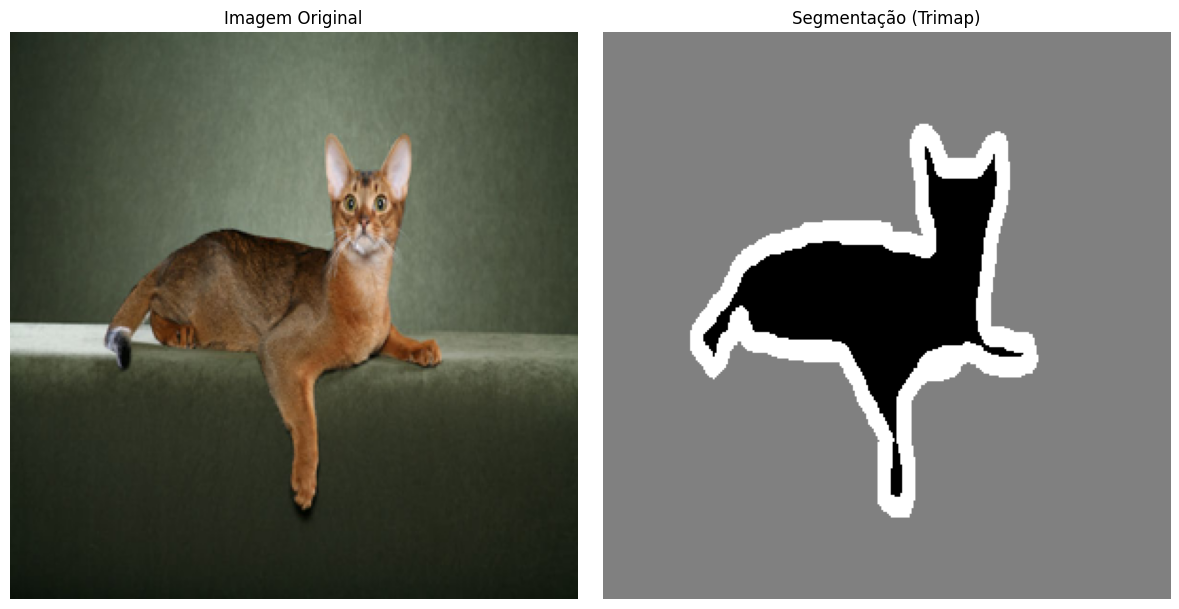

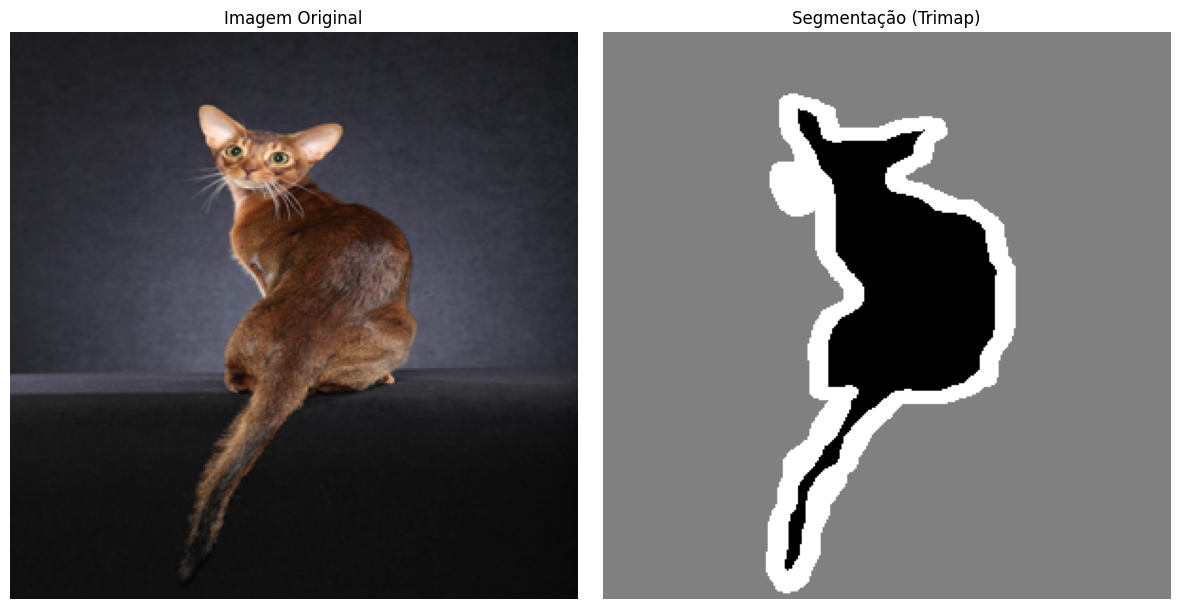

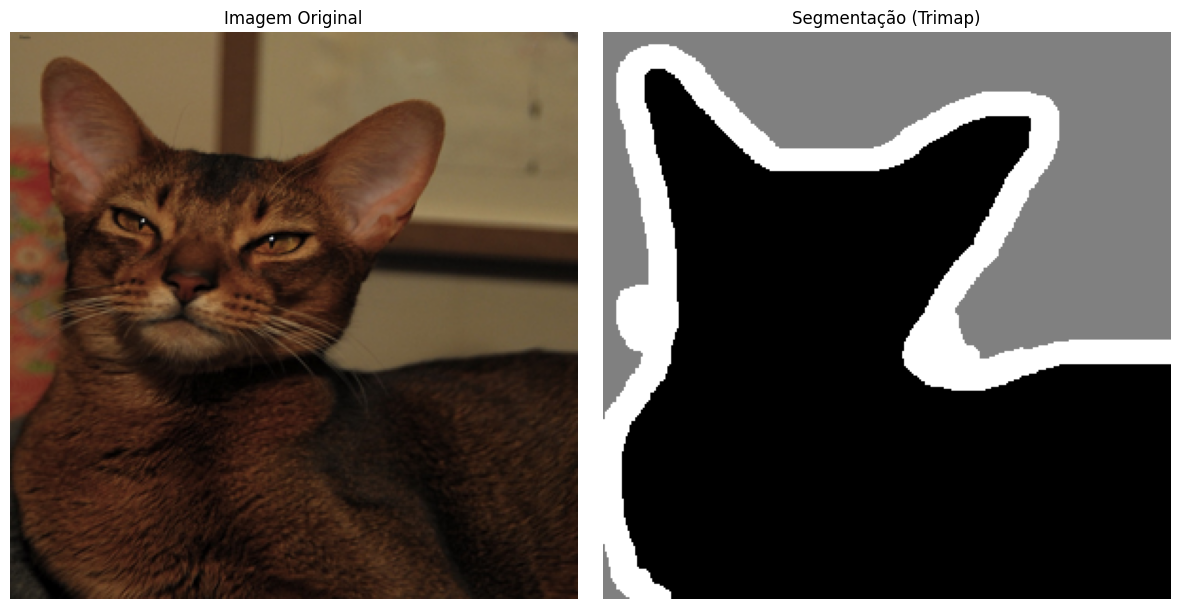

In [117]:
visualize_segmented_image(data,data_tri_segmented,3)

Combinando segmentação para deixar apenas objeto (gato) e fundo:

In [118]:
def combine_classes(data_seg):
    """
    Combina as classes 1 e 2 em uma única classe (1) e deixa o fundo como 0.
    
    :param annotation_path: Caminho para o arquivo de segmentação (trimap).
    :return: Array NumPy com a segmentação ajustada.
    """
    binary_annotation = []
    
    for img_seg in data_seg:
        binary_annotation.append(np.where(img_seg == 2, 0, 1))
    
    images_array = np.stack(binary_annotation, axis=0)

    return binary_annotation


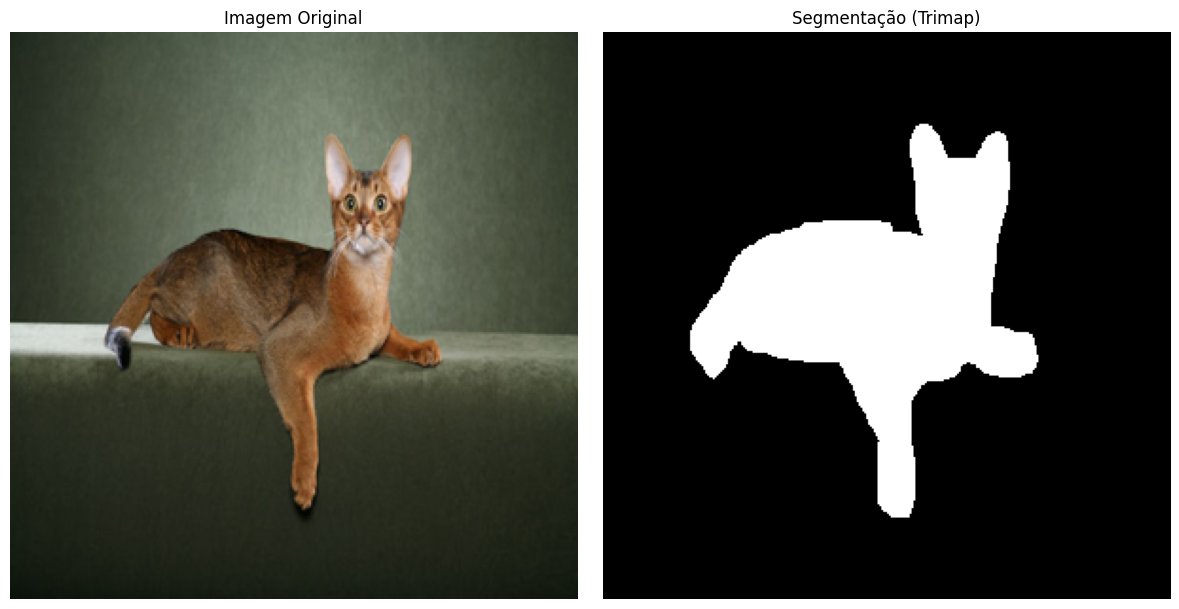

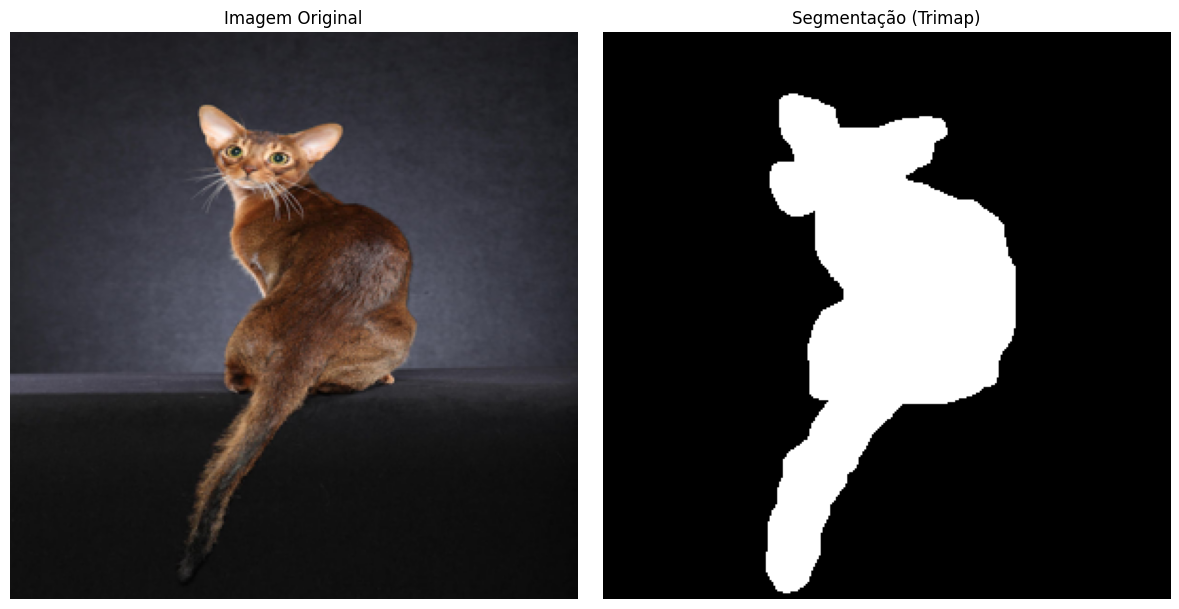

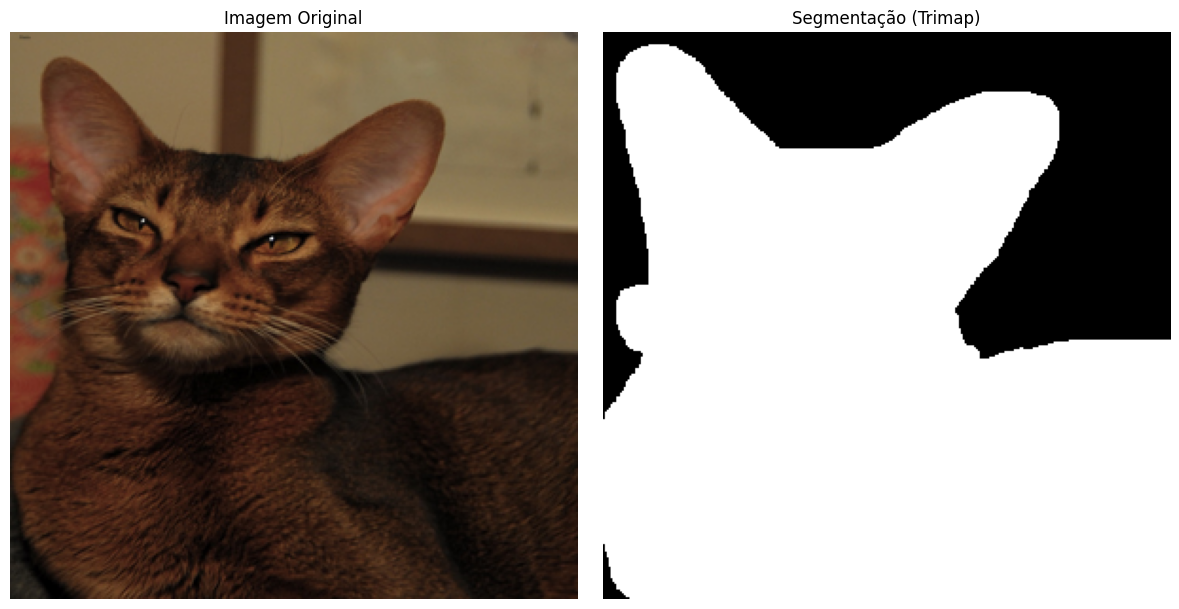

In [119]:
data_segmented = combine_classes(data_tri_segmented)

visualize_segmented_image(data,data_segmented,3)

# Preprocessing

Transforming images into grayscale: